# Extra Discussion 1 - Constrained Portfolio Optimization
## Via the HBS Case: Harvard and Inflation-Indexed Bonds

## FINM 36700: Portfolio and Risk Management

### Mark Hendricks

#### Autumn 2023

In [1]:
import pandas as pd
import numpy as np
import warnings
from scipy.optimize import minimize

# Data Processing

## Organize Return Statistics as provided in the Harvard Case
- Assumed (Exhibit 4)
- Historic (Exhibit 2)

The exhibits are a mess when loaded, function below cleans them up and returns the relevant data.

#### Problem with Data in Exhibit 2
Note: The historic correlation matrix in Exhibit 2 **is not positive definite!**
- This is clearly a mistake in the exhibit.
- It does not cause an obvious problem with the results below.
- But if you compare the analytic MV solution with a numerical optimization of the classic MV problem (no bounds) one sees that the numerical optimizer can take advantage of the matrix being negative definite to achieve a negative variance!
- Thus, the numerically optimized solution with constraints is suspect.

**Thus, the analysis with "Historic" data from Exhibit 2 should be taken with a grain of salt.** Yet it still illustrates the concept.

In [2]:
def read_harvard_stats_exhibit(df,description=None):

    # get the portion of the exhibit with actual data
    df.dropna(subset=[df.columns[0]],axis=0,how='any',inplace=True)
    df.set_index(df.columns[0],inplace=True)
    df.dropna(axis=1,how='all',inplace=True)
    df.dropna(axis=0,how='all',inplace=True)
    df.set_index(df.columns[0],inplace=True)
    df.index.name = description
    
    # deal with typos and bad formatting from the case exhbit
    if description == 'Assumed Stats':
        df.rename({'Infl-Indexed Bonds':'Inflation-Indexed Bonds'},axis=0,inplace=True)
    elif description == 'Historic Stats':
        df.rename({'Absolute Returnb':'Absolute Return', 'High Yieldb':'High Yield', 'Foreign Bondsb':'Foreign Bonds'},axis=0, inplace=True)

    # organize data
    df.columns = ['Mean','Vol'] + list(df.index)

    df = df.astype('float64')
    corr = df.drop(columns=['Mean','Vol'])
    
    ### Force the correlation matrix in Exhibit 2 to be positive definite
    HIST_CORR_FIX = [.80,.85]
    if description == 'Historic Stats':
        corr.loc['Absolute Return',['Domestic Equity','Foreign Equity']] = HIST_CORR_FIX
        corr.loc[['Domestic Equity','Foreign Equity'],'Absolute Return'] = HIST_CORR_FIX
    
    vol = df['Vol'] / 100
    mean = df['Mean'] / 100
    cov = corr * (np.outer(vol, vol.T))
    
    return {'mean':mean, 'vol':vol, 'cov':cov, 'corr':corr}

## Organize Optimization Parameters
### Also read in the HBS Solutions

In [3]:
def read_harvard_optimization_exhibit(df, description = None):
    df = df.dropna(axis=1,how='all').dropna(axis=0,how='all').set_index(df.columns[0])
    df.columns = df.iloc[-4,:]/100
    df = df.loc[cov.index]

    if description == 'Historic Stats':
        df.drop(index='Inflation-Indexed Bonds',inplace=True)
        
    hbs_solutions = df.loc[:,df.columns.notnull()]/100
    hbs_solutions.index.name = 'weights'

    bounds_df = df.iloc[:,-2:]
    if description == 'Policy':
        bounds_df /= 100
    bounds_df.columns = ['Min','Max']
    bounds_df.index.name = description
    
    return bounds_df, hbs_solutions

## Case has 4 combinations
### Two types of statistics
- Historic
- Assumed

### Two sets of bounds
- Long-only
- Policy

Our main focus, like that of case, is
- Assumed stats
- Policy constraints

In [4]:
DATAFILE = '../data/harvard_tips_exhibits.xlsx'

USE_HISTORIC_STATS = False
USE_LONGONLY_CONSTRAINT = False

In [5]:
if USE_HISTORIC_STATS:
    sheet_stats = 'Exhibit 2'
    stats_description = 'Historic Stats'
else:
    sheet_stats = 'Exhibit 4'
    stats_description = 'Assumed Stats'

if USE_LONGONLY_CONSTRAINT:
    sheet_constraint = 'Exhibit 5'
    constraint_description = 'Long-Only'
else:
    sheet_constraint = 'Exhibit 6'
    constraint_description = 'Policy'

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    rawdata_stats = pd.read_excel(DATAFILE,sheet_name=sheet_stats)
    rawdata_opt = pd.read_excel(DATAFILE,sheet_name=sheet_constraint)

output_stats = read_harvard_stats_exhibit(rawdata_stats, description = stats_description)    
mean = output_stats['mean']
cov = output_stats['cov']
nAssets = mean.shape[0]

bounds_df, hbs_solutions = read_harvard_optimization_exhibit(rawdata_opt, description = constraint_description)

# Constrained Optimization

### Objective
Minimize portfolio variance. 
- Portfolio weights: $\boldsymbol{w}$
- Return covariance matrix: $\boldsymbol{\Sigma}$
$$f(\boldsymbol{w}) = \boldsymbol{w}' \boldsymbol{\Sigma} \boldsymbol{w}$$

In [7]:
def objective(w):        
    return (w.T @ cov @ w)

### Constraints

#### Equality Constraints
- Targeted mean for the optimized portfolio: $\mu_p$
Define the following two functions:
$$g_{1}(\boldsymbol{w}) \equiv \boldsymbol{1}'\boldsymbol{w}$$
$$g_{2}(\boldsymbol{w}) \equiv \boldsymbol{\mu}'\boldsymbol{w}$$

These are imposed as equality constraints:
$$g_1(\boldsymbol{w}) = 1$$
$$g_2(\boldsymbol{w}) = \mu_p$$

#### Target mean
Below we analyze the problem for a target mean return of
- 8% if using the assume stats
- 12% if using the historic stats
The reason for the difference is that the historic stats are **much** more favorable, and it is easy to generate high mean returns.

In [8]:
if USE_HISTORIC_STATS:
    TARGET_MEAN = 0.12
else:
    TARGET_MEAN = 0.07

def fun_constraint_capital(w):
    return np.sum(w) - 1

def fun_constraint_mean(w):
    return (mean @ w) - TARGET_MEAN

constraint_capital = {'type': 'eq', 'fun': fun_constraint_capital}
constraint_mean = {'type': 'eq', 'fun': fun_constraint_mean}

cons = ([constraint_capital, constraint_mean])

### Inequality Constraints

**This cell's notation and setup is overkill for the simplicity of these constraints, but is noted here for more general problems.**

- Denote the $k\times k$ identity matrix as $\mathcal{I}_k$
- Denote the $i$ column of the identity matrix as $\boldsymbol{\iota}_i$

Define the following $k$ functions, for $1\le i\le n$: 
$$h_i(\boldsymbol{w}) \equiv \boldsymbol{\iota}_i' \boldsymbol{w}$$
For each $i$, we use the upper and lower inequality constraints:
$$h_i(\boldsymbol{w}) \le d_i^{\text{max}}$$
$$h_i(\boldsymbol{w}) \ge d_i^{\text{min}}$$

Stack the constraints into matrix notation. The inequality constraint functions are linear:
$$\boldsymbol{h}(\boldsymbol{w}) \equiv \mathcal{I}_k \boldsymbol{w}$$
and there are $2n$ total of them--$n$ upper and $n$ lower:
$$\boldsymbol{h}(\boldsymbol{w}) \le \boldsymbol{d}^{\text{max}}$$
$$\boldsymbol{h}(\boldsymbol{w}) \ge \boldsymbol{d}^{\text{min}}$$

### Boundary Constraints

Given that the inequality constraint functions are all linear, these constraints are simply boundary conditions.

The `scipy` package `minimize` implements boundary constraints specifically, via an iteration of tuples:

In [9]:
bounds = [tuple(bounds_df.iloc[i,:].values) for i in range(nAssets)]

## Solution

#### Default Tolerance
- Default tolerance is fine here, but be careful. Variance minimization for daily or even monthly variance leads to extremely small scaling of the objective function, and often the default tolerance will not be sufficient.
- Even in the example below, making the tolerance stricter impacts the weights to the second decimal place.

#### Method
- For the data given here the problem is not too hard to solve, so many methods will work fine.
- If using high dimensionality, nearly singular determinant, etc, it may matter more.
- Below we use `SLSQP` as it is fast and fairly robust for this application.
- At the end, we redo the optimization using `trust-constr` solely for the fact that this method automatically returns the Lagrange Multipliers which are useful for pedagogical reasons.

#### Initialize
- Try equally-weighted portfolio
- This satisfies the Long-Only constraint.
- May not satisfy the Policy constraint, but this problem is well-behaved, so it will be good enough as an initial guess

#### Verify!
- In a serious application, we would code the problem to verify that the answer returned by the solution is a "success" (obeys all the constraints) rather than a failed attempt. Try changing `TARGET_MEAN` to a big number, and you will see the optimizer fail to hit the target and obey the constraints.

In [10]:
TOL = 1e-12
METHOD = 'SLSQP'

w0 = np.ones(nAssets) / nAssets

solution = minimize(objective, w0, method=METHOD, bounds=bounds,constraints=cons, tol=TOL)
wstar = pd.DataFrame(data=solution.x, index=cov.columns, columns=['Bounded: Numerical'])

if solution.success:
    print('Optimization SUCCESSFUL.')
else:
    print('Optimization FAILED.')

print(f'Iterations: {solution.nit}.')

Optimization SUCCESSFUL.
Iterations: 31.


# Other Solutions for Comparison

#### HBS Case Exhibit Solution
Compare to Exhibits 5 and 6.
- Only applicable if `USE_HISTORIC_STATS` is `False`.
- (Case does not provide their solutions when using Historic data.)

#### Classic MV via Numerical Optimization
Solve numerically by dropping the inequality (bounds) constraints in `minimize`.
- Only applicable if `USE_HISTORIC_STATS` is `False`. 
- (Exhibit 2 correlation matrix is not positive definite.)

#### Analytic MV solution for verification.
- Calculate this on your own.
- The function doing it below is not available to you.
- If `USE_HISTORIC_STATS` is `True`, computation may not work correctly, but it is attempted.

#### Equal-weighted
- Just for illustration. 

In [11]:
if sheet_stats == 'Exhibit 4' and TARGET_MEAN in hbs_solutions.columns:
    wstar['Bounded: Case'] = hbs_solutions[TARGET_MEAN]   

In [12]:
if not USE_HISTORIC_STATS:
    METHOD = 'SLSQP'
    TOL = 1e-12
    w0 = np.ones(nAssets) / nAssets

    solutionMV = minimize(objective, w0, method=METHOD, constraints=cons, tol=TOL)
    wstar['MV: Numerical'] = solutionMV.x
    
    if solutionMV.success:
        print('Optimization SUCCESSFUL.')
    else:
        print('Optimization FAILED.')

    print(f'Iterations: {solutionMV.nit}.')

Optimization SUCCESSFUL.
Iterations: 63.


In [13]:
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns)

In [14]:
def MVweights(mean, cov, isexcess=True, target='TAN'):

    vecOnes = np.ones([len(mean)])
    
    wtsTan = np.linalg.solve(cov,mean)
    wtsGMV = np.linalg.solve(cov,vecOnes)

    wtsTan = wtsTan / wtsTan.sum()
    wtsGMV = wtsGMV / wtsGMV.sum()

    
    if type(target)==str:
        if target=='TAN':
            delta = 1
        else:
            delta = 0
    else:
        if isexcess:
            delta = target * (vecOnes.T @ np.linalg.solve(cov,mean)) / (mean.T @ np.linalg.solve(cov,mean))
        else:
            delta = (target - mean @ wtsGMV) / (mean @ wtsTan - mean @ wtsGMV)        

    if isexcess:
        wstar = wtsTan * delta
    else:
        wstar = wtsTan * delta + wtsGMV * (1-delta)

    return wstar

In [15]:
wstar['MV: Analytic'] = MVweights(mean=mean.values,cov=cov.values,isexcess=False,target=TARGET_MEAN)

In [16]:
wstar.insert(0,'Equally-Weighted',w0)

# Results

### Optimized Weights Comparison

In [17]:
display(wstar.style.format('{:.2%}'.format))

,Equally-Weighted,Bounded: Numerical,Bounded: Case,MV: Numerical,MV: Analytic
Domestic Equity,8.33%,22.00%,22.00%,-0.05%,-0.05%
Foreign Equity,8.33%,5.00%,5.00%,5.74%,5.74%
Emerging Markets,8.33%,19.00%,19.00%,19.87%,19.87%
Private Equity,8.33%,22.83%,22.80%,22.01%,22.01%
Absolute Return,8.33%,-6.00%,-6.00%,-0.65%,-0.65%
High Yield,8.33%,-6.92%,-6.90%,4.15%,4.15%
Commodities,8.33%,15.00%,15.00%,14.21%,14.21%
Real Estate,8.33%,16.42%,16.40%,17.35%,17.35%
Domestic Bonds,8.33%,1.00%,1.00%,-19.98%,-19.98%
Foreign Bonds,8.33%,2.90%,2.90%,15.95%,15.95%


### Using Bounds of...

In [18]:
display(bounds_df.style.format('{:.2%}'.format))

,Min,Max
Policy,,
Domestic Equity,22.00%,42.00%
Foreign Equity,5.00%,25.00%
Emerging Markets,-1.00%,19.00%
Private Equity,5.00%,25.00%
Absolute Return,-6.00%,14.00%
High Yield,-8.00%,12.00%
Commodities,-5.00%,15.00%
Real Estate,-3.00%,17.00%
Domestic Bonds,1.00%,21.00%


# Performance Stats

In [19]:
meanP = (mean.T @ wstar)
volP = pd.Series(np.diag(wstar.T @ cov @ wstar),index=wstar.columns).apply(np.sqrt)

sharpeP = (meanP-mean.loc['Cash'])/volP

performance = pd.DataFrame({'mean':meanP,'vol':volP,'Sharpe':sharpeP})
display(performance.style.format('{:.2%}'.format))

,mean,vol,Sharpe
Equally-Weighted,5.67%,6.58%,33.05%
Bounded: Numerical,7.00%,9.84%,35.57%
Bounded: Case,7.00%,9.84%,35.57%
MV: Numerical,7.00%,9.08%,38.54%
MV: Analytic,7.00%,9.08%,38.54%


### In the case of Assumed Statistics (Exhibit 4)...

The Bounded and Classic MV answers have similar Sharpe ratios.
- Bounded optimization does a good job?
- For these targeted mean returns, yes.
- But for large target mean, classic MV can get there with huge long-short positions, and the bounded solution will fail or will do so with bigger penalty.

Try `TARGET_MEAN` of 10%, 15%, 20% to get an idea of this.

Additionally, this analysis is impacted by the strange assumed mean return. Domestic equities are assumed to only have a 3% premium over cash!

# Which Constraints are most costly?

The Lagrange Multipliers give us a clue.
- Each is the derivative of the objective function with respect to the constraint boundary.
- Magnitude shows impact.
- Sign is an indication of whether constraint is upper or lower bound.
- Showing impact on objective (variance) so numbers are small.

Focus on their relative magnitudes.

### The importance of the constraints changes a lot
- between using the Long-Only or Policy Constraints
- between using the Historic and Assumed Stats

In [20]:
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

TOL = 1e-12
METHOD = 'trust-constr'

w0 = wstar['Bounded: Numerical']
solutionALT = minimize(objective, w0, method=METHOD, bounds=bounds,constraints=cons, tol=TOL)

pd.DataFrame(solutionALT.v[-1], index=mean.index, columns=['Lagrange Multipliers']).sort_values('Lagrange Multipliers',ascending=False).style.format('{:.2%}'.format)

,Lagrange Multipliers
Assumed Stats,
Commodities,0.14%
Emerging Markets,0.08%
Real Estate,0.00%
Private Equity,0.00%
Foreign Bonds,-0.00%
Inflation-Indexed Bonds,-0.00%
High Yield,-0.00%
Absolute Return,-0.13%
Domestic Bonds,-0.16%


# Figures

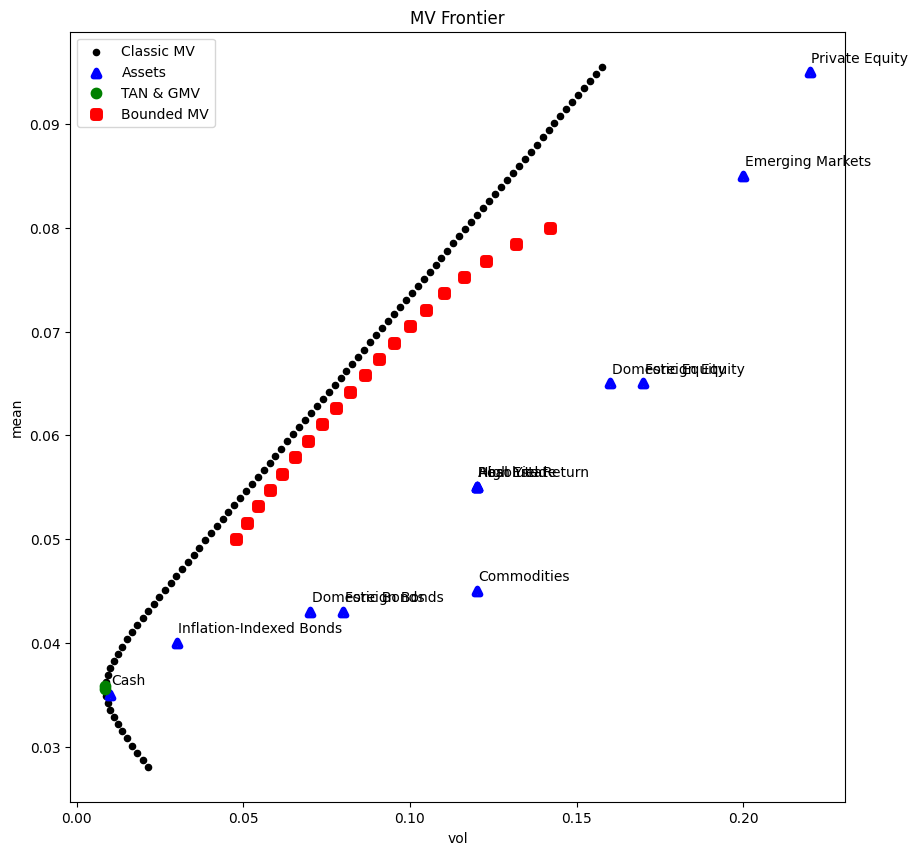

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

omega = pd.DataFrame(MVweights(mean=mean.values,cov=cov.values,isexcess=False,target='TAN'), index=mean.index).rename({0:'Tangency'},axis=1)

mean_ex = mean-mean['Cash']
cov_ex = cov.drop(columns=['Cash'],index=['Cash'])
omega['GMV'] = MVweights(mean=mean.values,cov=cov.values,isexcess=False,target='GMV')

omega_tan = omega['Tangency']
omega_gmv = omega['GMV']

vols = pd.Series(np.sqrt(np.diag(cov)), index=cov.index)
special_vols = pd.Series(np.sqrt(np.diag(omega.T @ cov @ omega)), index=omega.columns)
special_means = mean.T @ omega

if USE_LONGONLY_CONSTRAINT:
    MVgridmax = 350
else:
    MVgridmax = 200
    
delta_grid = np.linspace(-25,MVgridmax,100)
mv_frame = pd.DataFrame(columns=['mean','vol'],index=delta_grid)
for i, delta in enumerate(delta_grid):
    omega_mv = delta * omega_tan + (1-delta) * omega_gmv
    mv_frame['mean'].iloc[i] = omega_mv.T @ mean.T
    mv_frame['vol'].iloc[i] = np.sqrt(omega_mv.T @ cov @ omega_mv)
    
mv_assets = pd.concat([mean, vols],axis=1)
mv_special = pd.concat([special_means, special_vols],axis=1)
mv_assets.columns = ['mean','vol']
mv_special.columns = ['mean','vol']

ax = mv_frame.plot.scatter(x='vol',y='mean', c='k', figsize=(10,10), title='MV Frontier')
mv_assets.plot.scatter(x='vol',y='mean',ax=ax, c='b', marker='^', linewidth=4)
mv_special.plot.scatter(x='vol',y='mean',ax=ax, c='g', marker='o', linewidth=4)

for i in range(mv_assets.shape[0]):
    plt.text(x=mv_assets['vol'][i]+.0005, y=mv_assets['mean'][i]+.001, s=mv_assets.index[i])

TOL = 1e-12
METHOD = 'SLSQP'
w0 = np.ones(nAssets) / nAssets


if USE_LONGONLY_CONSTRAINT:
    maxmu = .12
    minmu = 0
else:
    maxmu = .08
    minmu = .05
    
mu_grid = np.linspace(minmu,maxmu,20)
mvcon_frame = pd.DataFrame(columns=['mean','vol'],index=mu_grid)
for i, mu in enumerate(mu_grid):
    TARGET_MEAN = mu
    omega_con = minimize(objective, w0, method=METHOD, bounds=bounds,constraints=cons, tol=TOL).x
    mvcon_frame['mean'].iloc[i] = omega_con.T @ mean.T
    mvcon_frame['vol'].iloc[i] = np.sqrt(omega_con.T @ cov @ omega_con)
    
mvcon_frame.plot.scatter(x='vol',y='mean', c='r', marker = 's', ax=ax, linewidth=5)

plt.legend(['Classic MV', 'Assets', 'TAN & GMV', 'Bounded MV'])
full_fig = plt.gcf()